<a href="https://colab.research.google.com/github/linhoangce/ml_with_pytorch_and_scikitlearn/blob/main/chapter11_multilayer_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Topics covered:

* Gaining a conceptual understanding of multiplayer NNs
* Implementing the fundamental backpropagation algorithm for NN training from scratch
* Training a basic multilayer NN for image classification

# Classifying handwritten digits

## Download and prepare MNIST dataset

In [1]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [2]:
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [3]:
y_train.shape

(60000,)

In [4]:
X_train = X_train.reshape(X_train.shape[0], 28*28)
X_train.shape

(60000, 784)

In [5]:
X_test = X_test.reshape(X_test.shape[0], 28*28)
X_test.shape

(10000, 784)

In [6]:
# normalize pixels values to range -1 to 1
X_train = ((X_train / 255.) - 0.5) * 2
X_test = ((X_test / 255.) - 0.5) * 2

X_train[0]

array([-1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.  

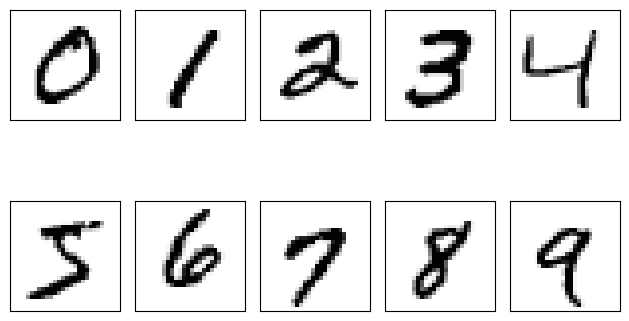

In [7]:
# reshape 784-pixe; vectors into original 28X28 pixels
# and plot images for visualization
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2,
                       ncols=5,
                       sharex=True,
                       sharey=True)

ax = ax.flatten()

for i in range(10):
  img = X_train[y_train == i][0].reshape(28, 28)
  ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

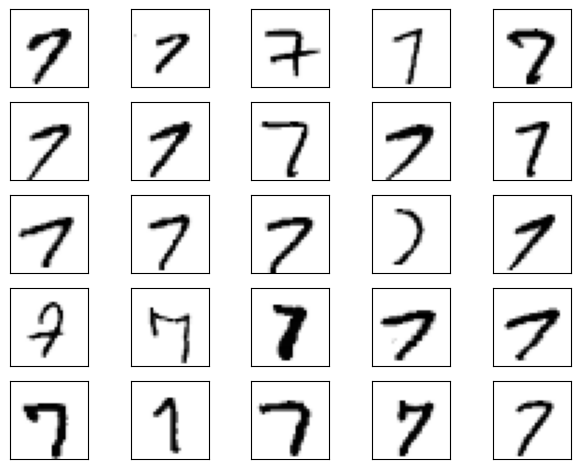

In [8]:
# plot multple examples of same digits to compare difference
fig, ax = plt.subplots(nrows=5,
                       ncols=5,
                       sharex=True,
                       sharey=True)

ax = ax.flatten()

for i in range(25):
  img = X_train[y_train == 7][i].reshape(28, 28)
  ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [9]:
# split X_train into train and val set, keep test same
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=5000,
                                                  random_state=123,
                                                  stratify=y_train)
X_train.shape, X_val.shape

((55000, 784), (5000, 784))

## Implementing a multilayer perceptron

In [10]:
import numpy as np

In [11]:
##################
### MODEL
##################

def sigmoid(z):
  return 1. / (1. + np.exp(-z))

def int_to_onehot(y, num_labels):
  ary = np.zeros((y.shape[0], num_labels))

  for i, val in enumerate(y):
    # print(f'i: {i}, val: {val}')
    ary[i, val] = 1 # assign 1 to row ith and col val-th
    # print(ary)
  return ary


In [12]:
int_to_onehot(y_train[:10], 10)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

We use MSE as Loss function:

$$ \text{Loss} = \frac{1}{n}\sum(a_\text{out} - y_\text{true})^2 $$

* The derivative w.r.t $a_\text{out}$ is:

$$ \frac{\delta\text{Loss}}{\delta a_\text{out}} = \frac{2(a_\text{out} - y_\text{true})}{n}$$

In [13]:
class NeuralNetMLP:

  def __init__(self,
               num_features,
               num_hidden,
               num_classes,
               random_seed=123):
    super().__init__()

    self.num_classes = num_classes

    # hidden
    rng = np.random.RandomState(random_seed)

    self.weight_h = rng.normal(loc=0.0,
                               scale=0.1,
                               size=(num_hidden, num_features))
    self.bias_h = np.zeros(num_hidden)

    # output
    self.weight_out = rng.normal(loc=0.0,
                                 scale=0.1,
                                 size=(num_classes, num_hidden))
    self.bias_out = np.zeros(num_classes)

  def forward(self, x):
    # Hidden layer
    # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
    # output dim: [n_examples, n_hidden]
    z_h = np.dot(x, self.weight_h.T) + self.bias_h
    a_h = sigmoid(z_h)

    # Output layer
    # input dim [n_examples, n_hidden] dot [n_classes, n_hidden].T
    # output dim [n_examples, n_classes]
    z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
    a_out = sigmoid(z_out)

    return a_h, a_out

  def backward(self, x, a_h, a_out, y):

    #########################
    ### Output layer weights
    #########################

    # onehot encoding
    y_onehot = int_to_onehot(y, self.num_classes)

    # Part 1: dLoss/dOutWeights
    ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
    ## wher DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
    ## for convenient re-use

    # input/output dim: [n_examples, n_classes]
    # calculate partial derivative of loss w.r.t sigmoid activation
    d_loss__d_a_out = 2. * (a_out - y_onehot) / y.shape[0]

    # input/output dim: [n_examples, n_classes]
    # sigmoid derivative
    d_a_out__d_z_out = a_out * (1. - a_out)

    # output dim: [n_examples, n_classes]
    # represents how much error flows back from output layer
    # into its input
    # "How wrong was I?" x "How sensitive is my activation to input?"
    delta_out = d_loss__d_a_out * d_a_out__d_z_out

    ### Gradient for output weights

    # [n_examples, n_hidden]
    d_z_out__dw_out = a_h

    # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
    # output dim: [n_classes, n_hidden]
    d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
    d_loss__db_out = np.sum(delta_out, axis=0)


    ######################################
    # Part 2: dLoss/dHiddenWeights
    ## = DeltaOut * dOutNet/dHiddenAct *
    ## dHiddenAct/dHiddenNet * dHiddenNet/dWeight

    # [n_classes, n_hidden]
    d_z_out__a_h = self.weight_out

    # output dim: [n_examples, n_hidden]
    d_loss__a_h = np.dot(delta_out, d_z_out__a_h)

    # [n_examples, n_features]
    d_a_h__d_z_h = a_h * (1. - a_h) # sigmoid derivative

    # [n_examples, n_features]
    d_z_h__d_w_h = x

    # output dim: [n_hidden, n_features]
    d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
    d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

    return (d_loss__dw_out,
            d_loss__db_out,
            d_loss__d_w_h,
            d_loss__d_b_h)


In [14]:
model = NeuralNetMLP(num_features=28*28,
                     num_hidden=50,
                     num_classes=10)


## Coding the neural network training loop

In [15]:
# define a mini-batch generator function
# taking in our dataset and divides it into mini-batches
# of a desired size for stochastic gradient descent training
import numpy as np

num_epochs = 50
minibatch_size = 100

def minibatch_generator(X, y, minibatch_size):
  indices = np.arange(X.shape[0])
  np.random.shuffle(indices)

  for start_idx in range(0,
                         indices.shape[0] - minibatch_size + 1, minibatch_size):
    batch_idx = indices[start_idx:start_idx + minibatch_size]

    yield X[batch_idx], y[batch_idx]

In [16]:
# test the function
for i in range(num_epochs):
  # iterate over minibatches
  minibatch_gen = minibatch_generator(X_train,
                                      y_train,
                                      minibatch_size)

  for X_train_mini, y_train_mini in minibatch_gen:
    break
  break

print(X_train_mini.shape, y_train_mini.shape)

(100, 784) (100,)


In [17]:
# implement MSE loss function
def mse_loss(targets, probas, num_labels=10):
  onehot_targets = int_to_onehot(targets, num_labels)
  return np.mean((onehot_targets - probas) ** 2)

# implement accuracy function
def accuracy(targets, predictions):
  return np.mean(targets == predictions)

In [18]:
# test preceding funtions and compute initial validation
# set MSE and accuracy of the model
_, probas = model.forward(X_val)
mse = mse_loss(y_val, probas)
print(f'Initial validation MSE: {mse:.1f}')

Initial validation MSE: 0.3


In [19]:
predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_val, predicted_labels)
print(f'Initila validation acc: {acc*100:.1f}%')

Initila validation acc: 9.2%


In [20]:
# compute MSE and accuracy incrementally by iterating
# over dataset one mini-batch at a time for memory efficiency
def compute_mse_and_acc(nnet, X, y,
                        num_labels=10,
                        minibatch_size=100):
  mse, correct_pred, num_examples = 0, 0, 0
  minibatch_gen = minibatch_generator(X, y, minibatch_size)

  for i, (features, targets) in enumerate(minibatch_gen):
    _, probas = nnet.forward(features)
    predicted_labels = np.argmax(probas, axis=1)
    onehot_targets = int_to_onehot(targets,
                                   num_labels=num_labels)
    loss = np.mean((onehot_targets - probas) ** 2)
    correct_pred += (predicted_labels == targets).sum()
    num_examples += targets.shape[0]
    mse += loss

  mse = mse / i
  acc = correct_pred / num_examples

  return mse, acc


In [21]:
# test function
mse, acc = compute_mse_and_acc(model,
                               X_val,
                               y_val)
print(f'Initial validation MSE: {mse:.1f}\n'
      f'Initial validation accuracy: {acc * 100:.1f}%')

Initial validation MSE: 0.3
Initial validation accuracy: 9.2%


In [22]:
# implement train function
def train(model,
          X_train, y_train,
          X_val, y_val,
          num_epochs,
          learning_rate):
  epoch_loss = []
  epoch_train_acc = []
  epoch_val_acc = []

  for e in range(num_epochs):
    # iterate over minibatches
    minibatch_gen = minibatch_generator(X_train,
                                        y_train,
                                        minibatch_size)

    for X_train_mini, y_train_mini in minibatch_gen:
      #### Compute outputs ####
      a_h, a_out = model.forward(X_train_mini)

      #### COmpute gradients ####
      d_loss__d_w_out, d_loss__d_b_out, \
      d_loss__d_w_h, d_loss__d_b_h = model.backward(X_train_mini,
                                                     a_h,
                                                     a_out,
                                                     y_train_mini)

      #### Update weights ####
      model.weight_h -= learning_rate * d_loss__d_w_h
      model.bias_h -= learning_rate * d_loss__d_b_h
      model.weight_out -= learning_rate * d_loss__d_w_out
      model.bias_out -= learning_rate * d_loss__d_b_out

    #### Epoch Logging ####
    train_mse, train_acc = compute_mse_and_acc(model,
                                               X_train,
                                               y_train)
    val_mse, val_acc = compute_mse_and_acc(model,
                                           X_val,
                                           y_val)

    train_acc, val_acc = train_acc * 100, val_acc * 100

    epoch_train_acc.append(train_acc)
    epoch_val_acc.append(val_acc)
    epoch_loss.append(train_mse)

    print(f'Epoch: {e + 1:03d}/{num_epochs:03d} '
          f'| Train MSe: {train_mse:.2f} '
          f'| Train Acc: {train_acc:.2f}% '
          f'| Valid acc: {val_acc:.2f}%')

  return epoch_loss, epoch_train_acc, epoch_val_acc

In [23]:
# train model over 50 epochs
np.random.seed(123)
epoch_loss, epoch_train_acc, epoch_val_acc = train(
    model,
    X_train, y_train,
    X_val, y_val,
    num_epochs=50,
    learning_rate=0.1
)

Epoch: 001/050 | Train MSe: 0.05 | Train Acc: 75.88% | Valid acc: 75.44%
Epoch: 002/050 | Train MSe: 0.03 | Train Acc: 85.17% | Valid acc: 84.54%
Epoch: 003/050 | Train MSe: 0.02 | Train Acc: 87.96% | Valid acc: 87.46%
Epoch: 004/050 | Train MSe: 0.02 | Train Acc: 89.13% | Valid acc: 88.32%
Epoch: 005/050 | Train MSe: 0.02 | Train Acc: 90.07% | Valid acc: 89.22%
Epoch: 006/050 | Train MSe: 0.02 | Train Acc: 90.57% | Valid acc: 89.68%
Epoch: 007/050 | Train MSe: 0.02 | Train Acc: 91.05% | Valid acc: 90.12%
Epoch: 008/050 | Train MSe: 0.02 | Train Acc: 91.42% | Valid acc: 90.76%
Epoch: 009/050 | Train MSe: 0.01 | Train Acc: 91.64% | Valid acc: 90.96%
Epoch: 010/050 | Train MSe: 0.01 | Train Acc: 91.96% | Valid acc: 91.08%
Epoch: 011/050 | Train MSe: 0.01 | Train Acc: 92.12% | Valid acc: 91.26%
Epoch: 012/050 | Train MSe: 0.01 | Train Acc: 92.38% | Valid acc: 91.48%
Epoch: 013/050 | Train MSe: 0.01 | Train Acc: 92.57% | Valid acc: 91.70%
Epoch: 014/050 | Train MSe: 0.01 | Train Acc: 92.74

## Evaluating the neural network performance


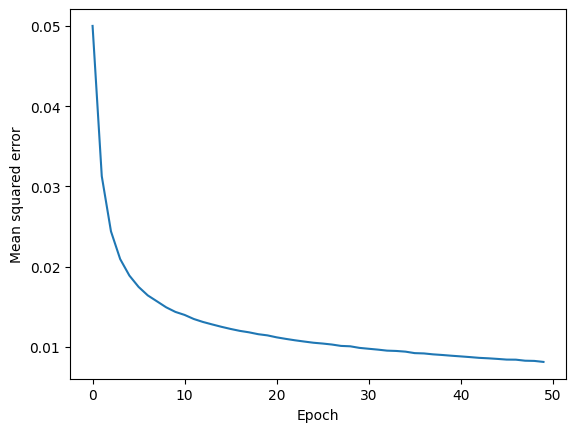

In [24]:
# plot training loss
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
plt.show()

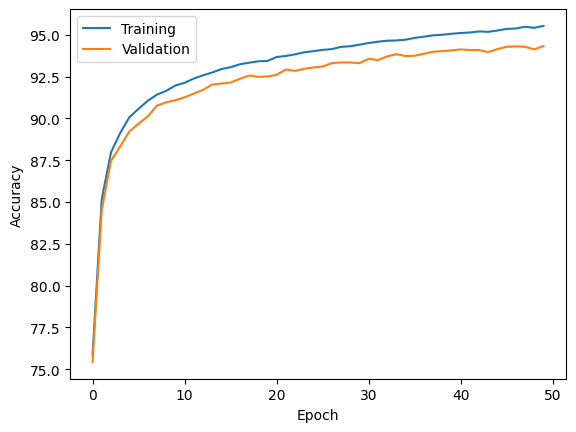

In [25]:
# plot training and validation accuracy
plt.plot(range(len(epoch_train_acc)),
         epoch_train_acc,
         label='Training')
plt.plot(range(len(epoch_val_acc)),
         epoch_val_acc,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.show()

In [26]:
# evaluate generalization performance of model
test_mse, test_acc = compute_mse_and_acc(model,
                                         X_test,
                                         y_test)
print(f'Test acc: {test_acc * 100:.2f}%')

Test acc: 94.89%


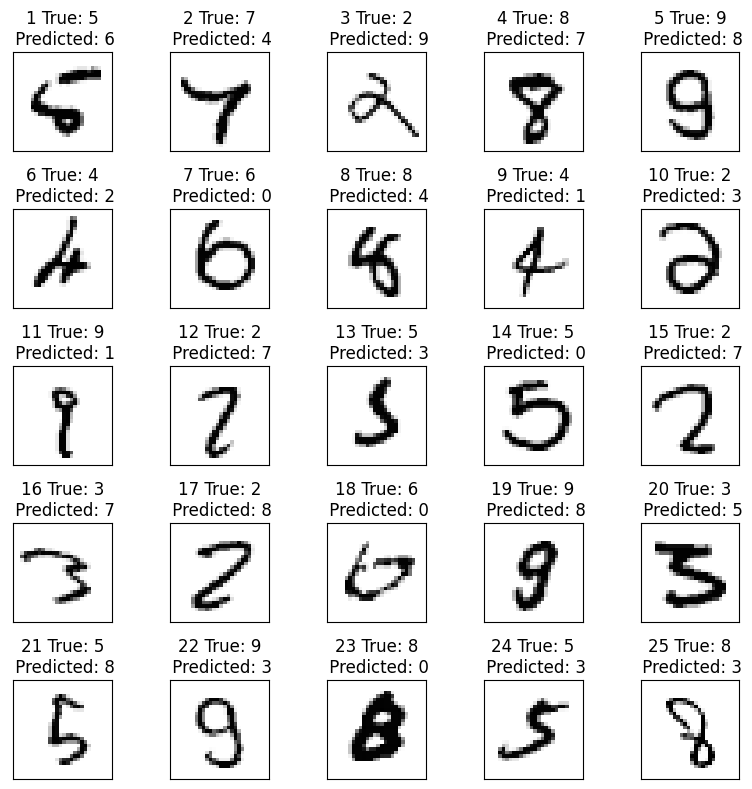

In [27]:
# extract and plot first 25 misclassified samples from test set
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]
_, probas = model.forward(X_test_subset)
test_pred = np.argmax(probas, axis=1)

misclassified_img = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]

fig, ax = plt.subplots(nrows=5,
                       ncols=5,
                       sharex=True,
                       sharey=True,
                       figsize=(8, 8))
ax = ax.flatten()

for i in range(25):
  img = misclassified_img[i].reshape(28, 28)
  ax[i].imshow(img,
               cmap='Greys',
               interpolation='nearest')
  ax[i].set_title(f'{i+1} '
                  f'True: {correct_labels[i]}\n'
                  f' Predicted: {misclassified_labels[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

# Training an artificial neural network

## Compute the loss function